## Formation Clustering
Section 4.3 in the paper

In [1]:
import os
wd = os.path.normpath(os.getcwd() + '/..')
os.chdir(wd)
os.getcwd()

'/home/hyunsung/Workspace/soccercpd'

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import itertools
from collections import Counter
from joblib import Parallel, delayed
from scipy.spatial import distance_matrix
from scipy.optimize import linear_sum_assignment
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt
from src.myconstants import *

pd.set_option('display.width', 250)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 20)
plt.rcParams['font.family'] = 'Arial'

In [3]:
%load_ext autoreload
%autoreload 2

from src.myconstants import *
from src.form_manager import FormManager

### Calculating the pairwise distances between formation graphs

In [21]:
form_periods = pd.read_pickle(f'data/form_periods.pkl')
form_periods

,activity_id,session,form_period,start_dt,end_dt,duration,coords,edge_mat,cluster,formation
0,12864,1,1,2020-01-01 14:00:00,2020-01-01 14:47:00,2820.0,"[[-719.0, 1625.0], [-1342.0, 660.0], [948.0, 1...","[[0.0, 0.977, 0.955, 0.2, 0.023, 0.828, 0.257,...",20,442
1,12868,1,1,2020-01-01 14:00:00,2020-01-01 14:47:00,2820.0,"[[-833.0, -1647.0], [14.0, 181.0], [-369.0, -1...","[[0.0, 0.338, 0.684, 0.994, 0.165, 0.042, 0.15...",5,4132
2,12868,2,2,2020-01-01 15:02:00,2020-01-01 15:50:00,2880.0,"[[-933.0, -1939.0], [-106.0, 618.0], [-231.0, ...","[[0.0, 0.164, 0.86, 0.993, 0.131, 0.036, 0.237...",20,442
3,12870,1,1,2020-01-01 13:30:00,2020-01-01 14:19:00,2940.0,"[[-1408.0, 43.0], [460.0, -1087.0], [-285.0, 5...","[[0.0, 0.22, 0.871, 0.098, 0.367, 0.962, 0.328...",12,352
4,12870,2,2,2020-01-01 14:33:00,2020-01-01 15:23:00,3000.0,"[[-1282.0, -147.0], [290.0, -888.0], [-209.0, ...","[[0.0, 0.416, 0.886, 0.054, 0.192, 0.998, 0.27...",-1,others
...,...,...,...,...,...,...,...,...,...,...
861,9064,2,3,2020-01-01 16:32:00,2020-01-01 16:51:00,1140.0,"[[-1589.0, 486.0], [-1684.0, -710.0], [-34.0, ...","[[0.0, 0.984, 0.515, 0.04, 0.009, 0.025, 0.813...",20,442
862,9281,1,1,2020-01-01 15:00:00,2020-01-01 15:47:00,2820.0,"[[-1478.0, 113.0], [-1176.0, -1051.0], [1666.0...","[[0.0, 0.982, 0.015, 0.022, 0.016, 0.191, 0.98...",0,343
863,9281,2,2,2020-01-01 16:03:00,2020-01-01 16:51:00,2880.0,"[[-1270.0, -89.0], [-1128.0, -1051.0], [1465.0...","[[0.0, 0.94, 0.052, 0.025, 0.047, 0.184, 0.974...",20,442
864,9285,1,1,2020-01-01 14:01:00,2020-01-01 14:48:00,2820.0,"[[-674.0, 1815.0], [-1457.0, 614.0], [-1564.0,...","[[0.0, 0.992, 0.237, 0.295, 0.148, 0.748, 0.20...",18,4231


In [5]:
def compute_delaunay_dists(i, n):
    form1 = form_periods.iloc[i]
    dist_row = []
    for j in range(n):
        form2 = form_periods.iloc[j]
        cost_mat = distance_matrix(form1['coords'], form2['coords'])
        _, perm = linear_sum_assignment(cost_mat)
        edge_mat1 = form1['edge_mat']
        edge_mat2 = form2['edge_mat'][perm][:, perm]
        dist_row.append(np.abs(edge_mat1 - edge_mat2).sum())
    return i, dist_row

In [6]:
n = len(form_periods)
dist_rows = Parallel(n_jobs=50)(delayed(compute_delaunay_dists)(i, n) for i in range(n))
dist_mat = np.zeros((n, n))
for i, dist_row in dist_rows:
    dist_mat[i] = dist_row
dist_mat

array([[ 0.   ,  8.14 ,  5.69 , ...,  4.42 ,  9.074,  9.928],
       [ 8.14 ,  0.   ,  6.742, ...,  9.808,  6.302, 10.644],
       [ 5.69 ,  6.742,  0.   , ...,  6.434,  6.36 ,  7.082],
       ...,
       [ 4.42 ,  9.808,  6.434, ...,  0.   , 16.838, 15.588],
       [ 9.074,  6.302,  6.36 , ..., 16.838,  0.   ,  6.846],
       [ 9.928, 10.644,  7.082, ..., 15.588,  6.846,  0.   ]])

In [7]:
pd.DataFrame(dist_mat).to_csv('data/form_dist_mat.csv', header=False, index=False)

### Initial clustering based on the distance matrix

In [5]:
dist_mat = pd.read_csv('data/form_dist_mat.csv', header=None).values
dist_mat

array([[ 0.   ,  8.14 ,  5.69 , ...,  4.42 ,  9.074,  9.928],
       [ 8.14 ,  0.   ,  6.742, ...,  9.808,  6.302, 10.644],
       [ 5.69 ,  6.742,  0.   , ...,  6.434,  6.36 ,  7.082],
       ...,
       [ 4.42 ,  9.808,  6.434, ...,  0.   , 16.838, 15.588],
       [ 9.074,  6.302,  6.36 , ..., 16.838,  0.   ,  6.846],
       [ 9.928, 10.644,  7.082, ..., 15.588,  6.846,  0.   ]])

In [23]:
n_clusters = 18
model = AgglomerativeClustering(n_clusters=n_clusters, affinity='precomputed', linkage='average')
model = model.fit(dist_mat)
counter = Counter(model.labels_)
outliers = []
for cluster, count in counter.items():
    if count < 15:
        outliers.append(cluster)
form_periods['cluster'] = np.where(np.isin(model.labels_, outliers), -1, model.labels_)
counts = form_periods['cluster'].value_counts()
counts

 1     338
 0     188
 16    143
 12    106
 5      50
-1      41
Name: cluster, dtype: int64

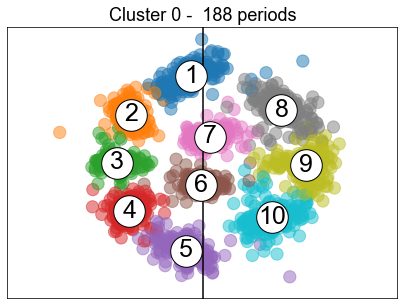

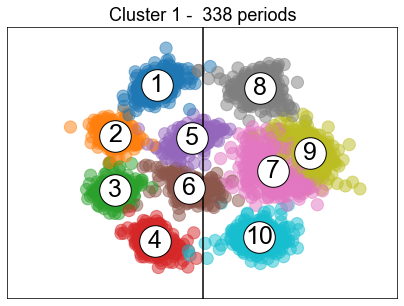

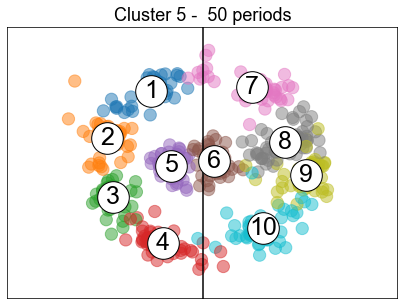

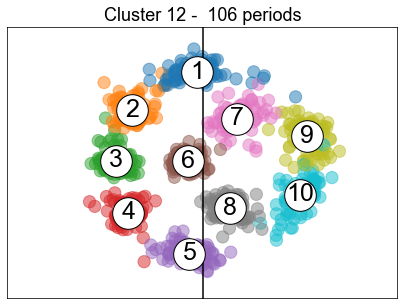

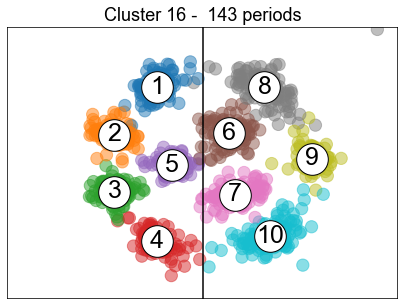

In [26]:
fm = FormManager(form_periods)
fm.visualize(group_type=LABEL_CLUSTER, ignore_outliers=True)

In [11]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, color_threshold=0, **kwargs)
    ax = plt.gca()
    ax.tick_params(axis='x', which='major', labelsize=15)

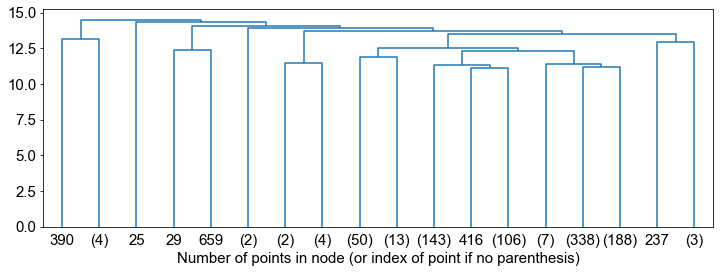

In [12]:
plt.figure(figsize=(12, 4))
model = AgglomerativeClustering(
    n_clusters=None, affinity='precomputed', linkage='average', distance_threshold=0
)
model.fit(dist_mat)
plot_dendrogram(model, truncate_mode='lastp', p=n_clusters)
plt.xlabel("Number of points in node (or index of point if no parenthesis)")
plt.show()

### Further clustering to separate "4-4-2" and "4-2-3-1"
Since two formation ("4-4-2" and "4-2-3-1") seem to be mixed in cluster 3, we further split the cluster 3 to separate them

In [27]:
cluster_idxs = form_periods[form_periods['cluster'] == 1].index
dist_mat_cluster = dist_mat[cluster_idxs][:, cluster_idxs]
dist_mat_cluster.shape

(338, 338)

In [28]:
submodel = AgglomerativeClustering(n_clusters=18, affinity='precomputed', linkage='average')
submodel = submodel.fit(dist_mat_cluster)
counter = Counter(submodel.labels_)
outliers = []
for cluster, count in counter.items():
    if count < 5:
        outliers.append(cluster)
form_periods.loc[cluster_idxs, LABEL_CLUSTER] = np.where(
    np.isin(submodel.labels_, outliers), -1, submodel.labels_ + n_clusters
)
counts = form_periods.loc[cluster_idxs, LABEL_CLUSTER].value_counts()
counts

 20    137
 26     81
 18     57
 23     30
-1      19
 19      8
 30      6
Name: cluster, dtype: int64

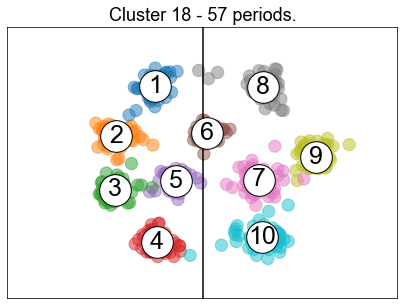

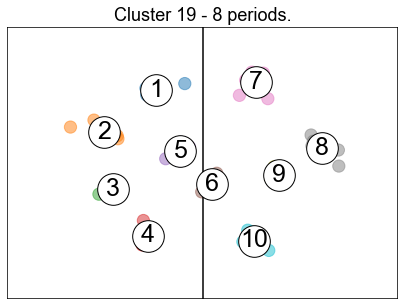

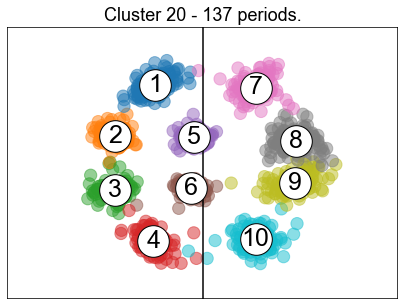

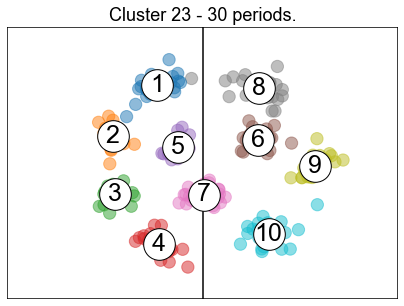

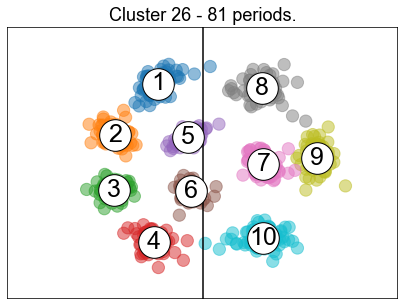

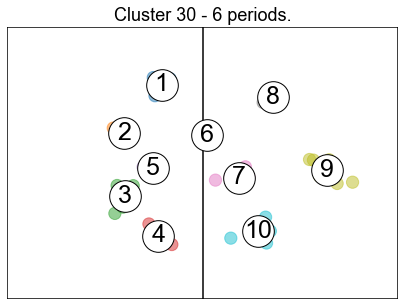

In [29]:
clusters = [c for c in np.sort(form_periods.loc[cluster_idxs, LABEL_CLUSTER].unique()) if c != -1]
for c in clusters:
    fm.visualize_group(c, group_type=LABEL_CLUSTER)
    # plt.savefig(f'img/cluster_c{c}.pdf', bbox_inches='tight')
    plt.title(f'Cluster {c} - {counts[c]} periods.')

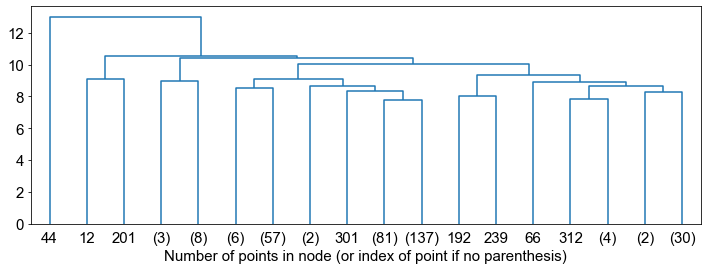

In [16]:
plt.figure(figsize=(12, 4))
submodel = AgglomerativeClustering(
    n_clusters=None, affinity='precomputed', linkage='average', distance_threshold=0
)
submodel.fit(dist_mat_cluster)
plot_dendrogram(submodel, truncate_mode='lastp', p=18)
plt.xlabel("Number of points in node (or index of point if no parenthesis)")
plt.show()

### Assigning a formation label per cluster

In [30]:
clus_to_form = {
    0: '343', 12: '352', 20: '442', 16: '433', 30: '433', 5: '4132', 
    18: '4231', 19: '4231', 23: '4231', 26: '4231', -1: 'others'
}
form_periods[LABEL_FORMATION] = form_periods[LABEL_CLUSTER].apply(lambda x: clus_to_form[x])
form_periods.to_pickle('data/form_periods.pkl')
form_periods

,activity_id,session,form_period,start_dt,end_dt,duration,coords,edge_mat,cluster,formation
0,12864,1,1,2020-01-01 14:00:00,2020-01-01 14:47:00,2820.0,"[[-719.0, 1625.0], [-1342.0, 660.0], [948.0, 1...","[[0.0, 0.977, 0.955, 0.2, 0.023, 0.828, 0.257,...",20,442
1,12868,1,1,2020-01-01 14:00:00,2020-01-01 14:47:00,2820.0,"[[-833.0, -1647.0], [14.0, 181.0], [-369.0, -1...","[[0.0, 0.338, 0.684, 0.994, 0.165, 0.042, 0.15...",5,4132
2,12868,2,2,2020-01-01 15:02:00,2020-01-01 15:50:00,2880.0,"[[-933.0, -1939.0], [-106.0, 618.0], [-231.0, ...","[[0.0, 0.164, 0.86, 0.993, 0.131, 0.036, 0.237...",20,442
3,12870,1,1,2020-01-01 13:30:00,2020-01-01 14:19:00,2940.0,"[[-1408.0, 43.0], [460.0, -1087.0], [-285.0, 5...","[[0.0, 0.22, 0.871, 0.098, 0.367, 0.962, 0.328...",12,352
4,12870,2,2,2020-01-01 14:33:00,2020-01-01 15:23:00,3000.0,"[[-1282.0, -147.0], [290.0, -888.0], [-209.0, ...","[[0.0, 0.416, 0.886, 0.054, 0.192, 0.998, 0.27...",-1,others
...,...,...,...,...,...,...,...,...,...,...
861,9064,2,3,2020-01-01 16:32:00,2020-01-01 16:51:00,1140.0,"[[-1589.0, 486.0], [-1684.0, -710.0], [-34.0, ...","[[0.0, 0.984, 0.515, 0.04, 0.009, 0.025, 0.813...",20,442
862,9281,1,1,2020-01-01 15:00:00,2020-01-01 15:47:00,2820.0,"[[-1478.0, 113.0], [-1176.0, -1051.0], [1666.0...","[[0.0, 0.982, 0.015, 0.022, 0.016, 0.191, 0.98...",0,343
863,9281,2,2,2020-01-01 16:03:00,2020-01-01 16:51:00,2880.0,"[[-1270.0, -89.0], [-1128.0, -1051.0], [1465.0...","[[0.0, 0.94, 0.052, 0.025, 0.047, 0.184, 0.974...",20,442
864,9285,1,1,2020-01-01 14:01:00,2020-01-01 14:48:00,2820.0,"[[-674.0, 1815.0], [-1457.0, 614.0], [-1564.0,...","[[0.0, 0.992, 0.237, 0.295, 0.148, 0.748, 0.20...",18,4231


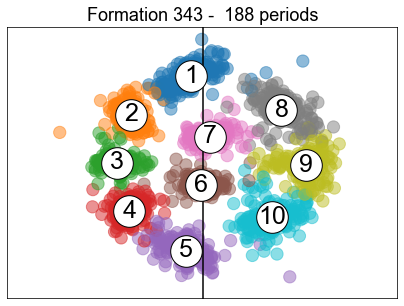

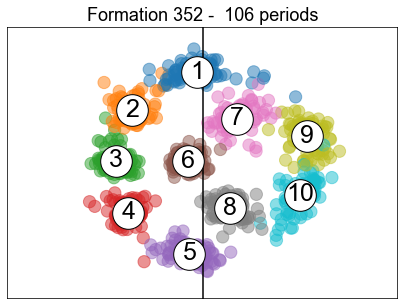

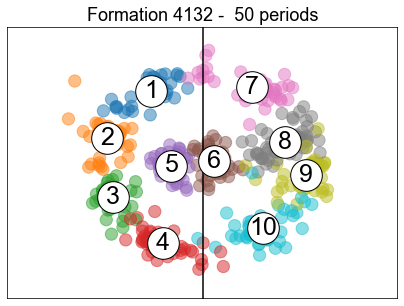

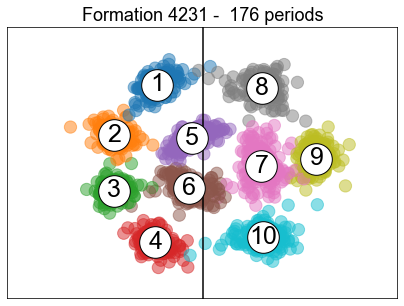

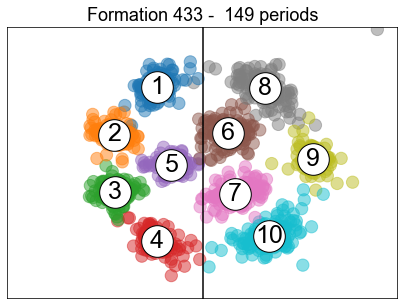

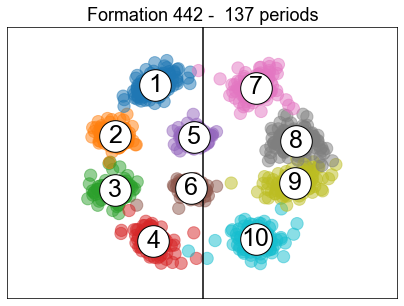

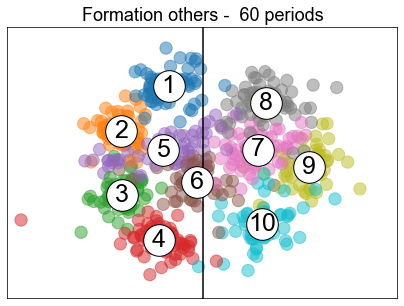

In [31]:
fm.visualize(group_type=LABEL_FORMATION, save=True)

In [19]:
total_dur = form_periods[LABEL_DURATION].sum()
form_durs = form_periods.groupby(LABEL_FORMATION)[LABEL_DURATION].sum()

counts = form_periods[LABEL_FORMATION].value_counts()
form_props = (form_durs / total_dur).round(4)
form_mean_durs = (form_durs / form_periods[LABEL_FORMATION].value_counts()).round(1)

counts.name = 'count'
form_props.name = 'proportion'
form_mean_durs.name = 'mean_dur'

pd.concat([counts, form_props, form_mean_durs], axis=1)

,count,proportion,mean_dur
343,188,0.2233,2770.5
4231,176,0.2091,2771.1
433,149,0.1735,2716.2
442,137,0.1633,2780.4
352,106,0.1222,2689.1
others,60,0.0506,1967.3
4132,50,0.0579,2699.2
